In [26]:
from typing import Dict
from pathlib import Path

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST 
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import brevitas.nn as qnn

In [17]:
project_path = Path.cwd().parents[1]
mnist_path = project_path/'data/mnist'

weight_bit_width = 8
weight_path = project_path/f'quant_he_code/weights/quant_hcnn_mnist_plain_{weight_bit_width}bits.pth'

In [7]:
test_dataset = MNIST(
    root=mnist_path, 
    train=False, 
    transform=transforms.Compose([
        ToTensor(),
        lambda x: (x*4).int(),
        lambda x: x.float()/4,
]))

test_loader = DataLoader(test_dataset, batch_size=64, pin_memory=True)

torch.Size([28, 28])
Processed MNIST data unique values = tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])


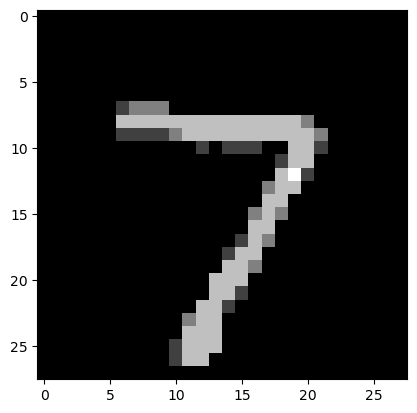

In [27]:
scale_factor_input = 1 / 3
im = test_dataset[0][0][0]
print(im.shape)
print(f"Processed MNIST data unique values = {im.unique()}")
plt.imshow(im, cmap='gray')

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    """
    PytorchLightining style
    """
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch) -> Dict:
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs) -> Dict:
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result) -> None:
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch + 1, result['val_loss'], result['val_acc']))

In [15]:
class MNISTConvQuantModel(ImageClassificationBase):
    """
    2 conv layers + 2 square activations + 1 linear layer
    """
    def __init__(self):
        super().__init__()
        self.conv1 = qnn.QuantConv2d(in_channels=1, out_channels=5, kernel_size=5, 
                                     stride=(2, 2), padding=0, bias=False, 
                                     weight_bit_width=weight_bit_width, 
                                     return_quant_tensor=True)
        self.conv2 = qnn.QuantConv2d(in_channels=5, out_channels=50, kernel_size=5, 
                                     stride=(2, 2), padding=0, bias=False, 
                                     weight_bit_width=weight_bit_width)
        self.fc1 = qnn.QuantLinear(in_features=800, out_features=10, bias=False, 
                                   weight_bit_width=weight_bit_width, 
                                   return_quant_tensor=True)

    def forward(self, xb):
        out = self.conv1(xb)
        out = out * out  # first square
        out = self.conv2(out)
        out = out.reshape(out.shape[0], -1)
        out = out * out  # second square
        out = self.fc1(out)

        return out

In [18]:
model = MNISTConvQuantModel()
model.load_state_dict(
    torch.load(weight_path, 
    map_location=torch.device('cpu'))
)

<All keys matched successfully>

In [46]:
def evaluate(model, val_loader) -> Dict:
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

acc = evaluate(model, test_loader)['val_acc']
print(f"test accuracy with trained {weight_bit_width}-bit weights = {acc}")

/tmp/ipykernel_104420/3874017255.py:2: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:363.)
  _, preds = torch.max(outputs, dim=1)


test accuracy with trained 8-bit weights = 0.9861664175987244


In [43]:
model.conv1.quant_weight() / model.conv1.quant_weight().scale - model.conv1.int_weight()

QuantTensor(value=tensor([[[[ 9.5367e-07, -9.5367e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  9.5367e-07,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00, -9.5367e-07,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  9.5367e-07]]],


        [[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -1.9073e-06,  0.0000e+00,  1.9073e-06,  0.0000e+00],
          [ 0.0000e+00,  9.5367e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.9073e-06,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  9.5367e-07,  0.0000e+00]]],


        [[[ 9.5367e-07,  1.9073e-06,  0.0000e+00,  0.0000e+00, -9.5367e-07],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -7.6294e-06,  0.0000e+00],
          [ 0.0000e+00, -1.9073e-06,  0.0000e+00, 

In [34]:
model.conv1.int_weight()

tensor([[[[  11,    9,   41,   21,  -17],
          [  -6,    4,    4,   11,    2],
          [ -68,   63,   13,    7,  -20],
          [ -16,  127,    6,  -80,   -3],
          [  41,   77,  -43,  -94,   11]]],


        [[[  32,  -70,  -14,   -3,   12],
          [   5,  -22,   75,   22,   -8],
          [ -43,  -13,  -10,  -85,  -82],
          [ -30,  -58,  -78,   24,   25],
          [  -3,   47,  -12,   15,   68]]],


        [[[  -9,  -18,  -21,    0,  -11],
          [ -12,  -46,  -66,  -88,   53],
          [  38,   18,    1, -108,  -13],
          [  43,   96,   69,  -31,  -35],
          [  -3,   10,   24,    0,   -9]]],


        [[[ -16,   49,  -27,   32,  -31],
          [ -95,   20,   59,   47,   32],
          [ -46,    7,   57,   17,   29],
          [ -85,  -52,  -12,  -19,  -20],
          [ -33,  -22,  -22,  -24,  -14]]],


        [[[  11,   33,    8,  -15,  -15],
          [   4,  -46,   -9,   -7,    5],
          [ -61,  -89,   -6,   27,   46],
          [ -38,  